In [3]:
import shapely
import math
import pyproj
import sys
import fiona
sys.path.append('../../../alg')

import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd, numpy as np, osmnx as ox
import distance_buffer as db, border_generators as bg, marching_army as ma

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon, LineString
from scipy.stats import truncnorm
%matplotlib inline

In [4]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

In [5]:
reload(ma)

<module 'marching_army' from '../../../alg/marching_army.pyc'>

In [6]:
reload(bg)

<module 'border_generators' from '../../../alg/border_generators.pyc'>

In [7]:
def plot_geoms(mpoly, scatterlist, scatter=False, fc="#cccccc", ec="#000000", alpha=0.5, zorder=1, savefig=False, figname="xxx.png"):
    
    fig, ax = plt.subplots(figsize=(10,10))
    
    for poly in mpoly:
        patch = PolygonPatch(poly, fc=fc, ec=ec, alpha=alpha, zorder=zorder)
        ax.add_patch(patch)
        
    for i in range(0, len(scatterlist)):
        if len(scatterlist[i]) > 0:
            ax.scatter(x=scatterlist[i]['x'], y=scatterlist[i]['y'], s=1, c='r', linewidth=0, zorder=2)
    
    west,south,east,north=mpoly.bounds
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    ax.axis('off')
    if savefig:
        plt.savefig(figname,  dpi=192 * 10)
    return fig,ax


# Let's clean up our old dev & streamline it

## 1 - read in the files and necessary data (data, pops)

 - Need the FACES data : each BG and it's associated data
 - Need the PLACES data : each BG and it's place code
 
 --- then we filter FACES for BG's we want with info from PLACES

In [8]:
# find a place basedd on it's commonly known name
def find_place(placename, fcollection):
    match = []
    for i in range(0, len(fcollection)):
        if fcollection[i]['properties']['NAME10'] == placename:
            match = fcollection[i]
    
    return match

In [9]:

def match_place_to_faces(placefp10, faces_collec):
    matches = []
    for i in range(0, len(countyfaces)):
        if countyfaces[i]['properties']['PLACEFP10'] == placefp10:
            matches.append(countyfaces[i])
    
    return matches

In [10]:
proj2 = partial(pyproj.transform, pyproj.Proj(init='epsg:4269'),pyproj.Proj(init='epsg:3857'))

In [11]:
# read in FACES file 
countyfaces = fiona.open("../../../data/CA_WalnutCreek/CTY_faces/tl_2010_06013_faces.shp")

In [12]:
# read in CA places (to get the place code)
ca_places = fiona.open("../../../data/CA_WalnutCreek/CA_places/tl_2010_06_place10.shp")

In [13]:
# find the place code
m = find_place("Walnut Creek", ca_places)

In [14]:
# get the shapely geometry from this place
wc_census10 = shapely.geometry.shape(m['geometry'])
wc_census10 = transform(proj2, wc_census10)

In [15]:
# turn the poly into a multipolygon for more uniform processing
wc_census10 = MultiPolygon([wc_census10])

In [16]:
#read in pop for entire state BGs
ca_pop_bg = fiona.open("../../../data/CA_WalnutCreek/CA_pop_bg/tabblock2010_06_pophu.shp")

In [17]:
#filter pop info to contra costa county
cc_pop_bg = []
for i in range(0, len(ca_pop_bg)):
    if ca_pop_bg[i]['properties']['COUNTYFP10'] == '013':
        cc_pop_bg.append(ca_pop_bg[i])

In [18]:
# match the place code to the faces to get the BG info
wc_matches = match_place_to_faces(m['properties']['PLACEFP10'], countyfaces)

In [19]:
#filter cc county to WC pop info

wc_pop_bg = []
for i in range(0,len(wc_matches)):
    matchstr = str(wc_matches[i]['properties']['STATEFP10'])+ str(wc_matches[i]['properties']['COUNTYFP10'])+str(wc_matches[i]['properties']['TRACTCE10'])+str(wc_matches[i]['properties']['BLOCKCE10'])
    for j in range(0, len(cc_pop_bg)):
        if cc_pop_bg[j]['properties']['BLOCKID10'] == matchstr:
            wc_pop_bg.append(cc_pop_bg[j])

In [20]:
len(wc_pop_bg)

1614

In [21]:
# remove BG's with duplicate ID's
temp_wc_pop_bg = []
dups = []
listofids = []
for i in range(0, len(wc_pop_bg)):
    tid = str(wc_pop_bg[i]['properties']['BLOCKID10'])
    if tid not in listofids:
        listofids.append(tid)
        temp_wc_pop_bg.append(wc_pop_bg[i])
    else:
        dups.append(wc_pop_bg[i])

In [22]:
# loop to make sure duplicates removed didnt have a differnet population
for i in range(0, len(dups)):
    thedup = str(dups[i]['properties']['BLOCKID10'])
    for j in range(0, len(temp_wc_pop_bg)):
        if thedup == str(temp_wc_pop_bg[j]['properties']['BLOCKID10']):
            p1 = dups[i]['properties']['POP10']
            p2 = temp_wc_pop_bg[j]['properties']['POP10']
            if not p1==p2:
                print p1
                print p2

In [23]:
print len(temp_wc_pop_bg)
wc_pop_geoms = temp_wc_pop_bg


987


In [24]:
wc_pop_schema = temp_wc_pop_bg 

In [25]:
# transform all the matching BGs to the correct projection
twc_pop_bg = []
for l in wc_pop_geoms:
    twc_pop_bg.append(transform(proj2, shapely.geometry.shape(l['geometry'])))

In [26]:
# turn into a multipolygon for easier processing
wc_pop_geoms = MultiPolygon(twc_pop_bg)

In [27]:
print len(wc_census10)
print len(wc_pop_bg)
print len(wc_pop_geoms)
print wc_pop_geoms[0]
print len(wc_pop_schema)
print wc_pop_schema[0]
print len(twc_pop_bg)
print twc_pop_bg[0]


1
1614
987
POLYGON ((-13589431.59022971 4567737.096114609, -13589426.69217211 4567737.096114609, -13589412.22063831 4567737.237221922, -13589407.43390021 4567737.378329235, -13589407.32258071 4567715.506718446, -13589407.32258071 4567649.892162615, -13589407.32258071 4567628.161842011, -13589427.24876957 4567627.738524526, -13589487.36129459 4567626.891889614, -13589507.39880294 4567626.750783806, -13589516.97227915 4567626.468572186, -13589546.02666624 4567625.904148972, -13589555.71146194 4567625.904148972, -13589559.94160259 4567633.806076756, -13589572.85466352 4567657.794108657, -13589577.19612367 4567665.83716706, -13589591.55633798 4567679.524491301, -13589634.97093939 4567720.868786501, -13589641.42746985 4567727.07750035, -13589649.44247319 4567734.838397875, -13589635.86149531 4567734.979505152, -13589625.39746318 4567734.979505152, -13589553.26243314 4567735.826148884, -13589529.32874263 4567736.108363478, -13589509.73651224 4567736.249470775, -13589451.0711406 4567736.81389

### Block groups shaded by population 

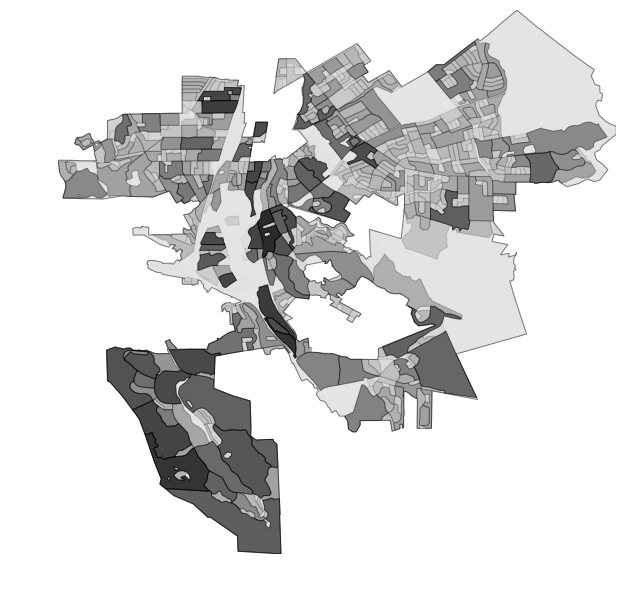

In [28]:
fig6, ax6 = plt.subplots(figsize=(10,10))
for polygon in wc_census10:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=1)
    ax6.add_patch(patch)

for i in range(0, len(wc_pop_geoms)):#p in multi_twc_pop_bg:
    #tpoly = Polygon([[p.x, p.y] for p in tpoly_list['geometry']])
    tpop = wc_pop_schema[i]['properties']['POP10']
    if tpop ==0: 
        tpop = 1
    patch = PolygonPatch(wc_pop_geoms[i], fc='#000000', ec='k', alpha=(tpop/(tpop+300.0)), zorder=2)
    ax6.add_patch(patch)
        

#west,south,east,north=multitpoly.bounds
west,south,east,north=wc_census10.bounds

ax6.set_xlim(west, east)
ax6.set_ylim(south, north)
ax6.axis('off')
#plt.savefig("images/population_blockgroups1.png",  dpi=192 * 10)
plt.show()

# Generate the random points in the whole RoI

In [29]:
def gen_n_random_coords(bds, n):
    xs = []
    ys = []
    for i in range(0,n):
        xs.append(ma.gen_rand_pt(bds[0], bds[2]))
        ys.append(ma.gen_rand_pt(bds[1],bds[3]))
    return xs, ys

In [30]:
#generate points for the whole RoI
west,south,east,north = wc_census10.bounds
xs,ys = gen_n_random_coords([west,south,east,north], 5000)
random_pts_all = gpd.GeoDataFrame(data={'x':xs, 'y':ys})
    
random_pts_all['geometry'] = random_pts_all.apply(lambda row: Point((row['x'], row['y'])), axis=1)
all_pts_sindex = random_pts_all.sindex

#now find ones that intercept the region by BG

pts_per_bg = []
pops_per_bg= []


for i in range(0,len(wc_pop_schema)):
    tbg_pop = wc_pop_schema[i]['properties']['POP10']
    pops_per_bg.append(tbg_pop)
    all_precise_matches = []
    if tbg_pop > 0: # only check for point intersections if the population >0
        poly = wc_pop_geoms[i]
        polybds = poly.bounds 
        
        all_possible_matches_index = list(all_pts_sindex.intersection(polybds))
        all_possible_matches = random_pts_all.iloc[all_possible_matches_index]
        all_precise_matches = all_possible_matches[all_possible_matches.intersects(poly)]
        
        while len(all_precise_matches)==0:
            #gen new random points focused on the BG at hand
            tx, ty = gen_n_random_coords(polybds, 10)
            trandom_pts = gpd.GeoDataFrame(data={'x':tx, 'y':ty})
            trandom_pts['geometry'] = trandom_pts.apply(lambda row: Point((row['x'], row['y'])), axis=1)
            trandom_pts_sindex = trandom_pts.sindex
            
            tpossible_matches_index = list(trandom_pts_sindex.intersection(polybds))
            tpossible_matches = trandom_pts.iloc[tpossible_matches_index]
            all_precise_matches = tpossible_matches[tpossible_matches.intersects(poly)]
            
        
        # make sure there's not more points than people in the bg
        if len(all_precise_matches) > tbg_pop:
            all_precise_matches = all_precise_matches[0:tbg_pop]
        
    pts_per_bg.append(all_precise_matches)
        

            
            #now check if they intersect w the bg
            
            
        
        #make sure there is >0 pt in each area with a non-0 population

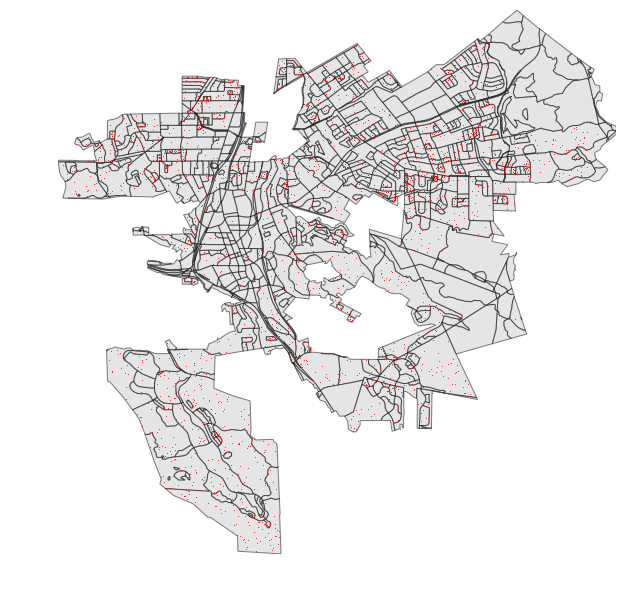

In [31]:
fig1, ax1 = plot_geoms(wc_pop_geoms, scatterlist=pts_per_bg, scatter=True )


### Integer partition the populations amongst the pts

In [32]:
# could split pop evenly or randomly amongst pop. pts
# pts_per_bg : list of x,y coords specifying randomly generated pts in the bg's
# pop_list : the population per the entire bg
def assign_pops_to_pts(pts_per_bg, pop_list):
    
    pops = []
    for i in range(0, len(pop_list)):
        print "IIIIIIIIII "+ str(i)
        tpop = pop_list[i]
        tpops = []
        
        # if there is a nonzero pop, distribute the pop amongst the generated random pts in the BG
        if tpop > 0:
            tpts = len(pts_per_bg[i])
            tmax = tpop
            # make sure theres not more pts than total pop
            if tpop < tpts:
                pts_per_bg[i] = pts_per_bg[i][0:tpop]
            elif tpop == tpts:
                tpops = [1]*tpts-1
                tmax=1
                continue
                
            print "HERE"
            partition_not_found = True
            
            cnt = len(tpops)
            while cnt < tpts-1:
                print "stuck here 111"
                while partition_not_found:
                   
                    print "stuck here 222"
                    print len(tpops)
                    print "tpops"+str(tpops)
                    print tpts
                    print cnt
                    
                    t = np.random.randint(1,tmax)
                    #print t
                    tpops.append(t)
                    cnt += 1
                    tmax = tmax-t
                    print "t "+str(t)
                    print "tmaxxxx "+str(tmax)
                    
                    spacesleft = abs(tpts-cnt)-1
                    # didn't reach partition before we ran out; restart
                    if tmax == 1:
                        "POOP HERE"
                        tpops = []
                        cnt = 0
                        tmax = tpop
                        break
                    elif tmax == spacesleft:
                        tpops.extend([1]*spacesleft)
                        tmax=1
                        continue
                        
                    #elif tmax == 1 
                    # check if we reached the partition; set last pts pop to remainder   
                    if cnt+1 == tpts:
                        print "IUHn  "+ str(tpops)
                        partition_not_found = False
                        break
                        
                    
                    
                    
                    #if tmax==1:
            
                     #   if cnt+1 == tpts:
                     #       partition_not_found = False
                     #       cnt = tpts+1
                     #       break
                     #   else:
                     #       cnt = 0
                     #       #tmax = math.ceil(tpop/2)
                     #       tpops = []
                     #       break
                        # else dont change part. flag and keep trying to find the right length partition
                  #  if len(tpops) == tpop-1:
                  #      cnt = tpts+1
                  #      tpops = []
                   #     break
                    
                    
                    #print tmax
                
                
            tpops.append(tmax)
            print "tmax "+str(tmax)
            cnt += 1
        pops.append(tpops)
        
    return pops

In [33]:
def assign_pops_to_pts_2(pts_per_bg, pops_per_bg):
    pop_partitions = []
    print "LDUHKUH"
    for i in range(0, len(pts_per_bg)):
        bgpop = pops_per_bg[i]
        bgpts = pts_per_bg[i]
        numpts = len(bgpts)
        pop_remains = bgpop
        pt_remains = numpts
        #print "NEW IIIII"
        
        partition = []
        partition_not_found = True
        # only partition pts if nonzero pop
        if bgpop == 0:
            #print "0 pop"
            pop_partitions.append(partition)
            partition_not_found = False
        elif bgpop == numpts: # simple partition each pt gets 1
            #print "each part gets 1"
            partition = [1]*numpts
            pop_partitions.append(partition)
            partition_not_found = False
        elif numpts > bgpop: # too many pts for the total pop, shave off some pts and assign 1's
            #print "too many pops for the pt"
            pts_per_bg[i] = pts_per_bg[i][0:bgpop]
            partition = [1]*bgpop
            pop_partitions.append(partition)
            partition_not_found = False
            
        # non simple partition case; now find the partition
        while partition_not_found: # loop until we find the partition
            #print "IN WHILE"
            #print i
            #print "bgpop "+str(bgpop)
            #print "numpts "+str(numpts)
            #print "pop_remains "+str(pop_remains)
            #print "pt_remains "+str(pt_remains)
                
            if pop_remains == pt_remains:
                #print "pop remain is pt remain"
                # if the # pts left ever =='s the # pop left, 
                # just assign 1's to the rest of the pts
                partition.extend(([1]*pop_remains))
                pop_partitions.append(partition)
                partition_not_found = False
                continue
            elif pop_remains < pt_remains: # not enough pop left to cover the remaining pts; start over
                pop_remains = bgpop
                pt_remains = numpts
                partition = []
                
            if pt_remains == 1:
                #print "last one,"
                partition.append(pop_remains)
                pop_partitions.append(partition)
                partition_not_found = False
                continue
            
                    
            randnum = np.random.randint(1,pop_remains)
            partition.append(randnum)
            # decrease remaining pts and pops accordingly
            pop_remains = pop_remains-randnum
            pt_remains -= 1
    
    #print pop_partitions
    return pop_partitions

In [34]:
%%time
poptest3 = assign_pops_to_pts_2(pts_per_bg, pops_per_bg)

LDUHKUH
CPU times: user 17.7 ms, sys: 3.34 ms, total: 21 ms
Wall time: 18.6 ms


In [35]:
#make sure all the sums and pops are equal
def test_pop_pt_agreement(pops_bg, popassigs, pts_bg):
    for i in range(0, len(popassigs)):
        t = popassigs[i]
        pts = pts_bg[i]
        #print t
        tsum = 0
        ptcnt = 0
        for j in range(0, len(t)):
            tsum +=t[j]
        for j in range(0, len(pts)):
            ptcnt += 1
        if not tsum == pops_bg[i]:
            print "POP DISAGREEMENT"
            print "I "+str(i)
            print tsum
            print pops_bg[i]
        if not ptcnt == len(t):
            print "PTCNT DISAGREEMENT"
            print ptcnt
            print len(t)
            

In [36]:
test_pop_pt_agreement(pops_per_bg, poptest3, pts_per_bg)

## Now we'll get the grid points for the candidate facitility locations generated

In [38]:
print wc_pop_geoms.bounds
print bounds
print interval
print stopx, stopy

(-13592111.050373102, 4557199.7523299, -13578818.94657493, 4571791.477797462)


NameError: name 'bounds' is not defined

In [39]:
# get the largest diagonal dist and this is what we will make 
#our regtangle of points on the grid based on (so when we shift/rotate the whole 
#shape will be covered still)

[west, south, east, north] = wc_pop_geoms.bounds
bounds = [west,south,east,north]
diags = [db.eucdist(west,north,east,south)[0], db.eucdist(west,south,east,north)[0]]
maxdiag = max(diags)
print maxdiag

19738.2490485


In [52]:
optdist = 100*math.sqrt(3)
shift = optdist/2.0
interval = int(math.ceil(maxdiag/optdist))
#y_int = int(math.ceil((abs(bounds[1]-bounds[3]))/optdist))

stopx = bounds[0]+(interval*optdist)
stopy = bounds[1]+(interval*optdist)

# create the equally spaced coord points for the "grid" cand pts
xs = np.linspace(west,stopx,interval)
ys = np.linspace(south,stopy,interval)

# create the grid
x_grid,y_grid = np.meshgrid(xs, ys)

#tcoords = np.vstack([x_grid.ravel(), y_grid.ravel()])

# create the GDF for the rtree intersection
gridgdf = gpd.GeoDataFrame(data={'x':x_grid.flatten(), 'y':y_grid.flatten()})


# transform the grid pts for indexing
gridgdf['geometry'] = gridgdf.apply(lambda row: Point((row['x'], row['y'])), axis=1)

#create the grid index
grid_index = gridgdf.sindex

In [53]:
xs

array([-13592111.0503731 , -13591936.31250402, -13591761.57463494,
       -13591586.83676586, -13591412.09889677, -13591237.36102769,
       -13591062.62315861, -13590887.88528953, -13590713.14742044,
       -13590538.40955136, -13590363.67168228, -13590188.9338132 ,
       -13590014.19594412, -13589839.45807503, -13589664.72020595,
       -13589489.98233687, -13589315.24446779, -13589140.50659871,
       -13588965.76872962, -13588791.03086054, -13588616.29299146,
       -13588441.55512238, -13588266.81725329, -13588092.07938421,
       -13587917.34151513, -13587742.60364605, -13587567.86577697,
       -13587393.12790788, -13587218.3900388 , -13587043.65216972,
       -13586868.91430064, -13586694.17643156, -13586519.43856247,
       -13586344.70069339, -13586169.96282431, -13585995.22495523,
       -13585820.48708614, -13585645.74921706, -13585471.01134798,
       -13585296.2734789 , -13585121.53560982, -13584946.79774073,
       -13584772.05987165, -13584597.32200257, -13584422.58413

In [41]:
# zip the grid so the coord points all match up 
gridtzip = np.array(zip(x_grid,y_grid))


In [42]:
# create the GDF for the rtree intersection
gridgdf = gpd.GeoDataFrame(data={'x':x_grid.flatten(), 'y':y_grid.flatten()})


In [43]:
# transform the grid pts for easy indexing
gridgdf['geometry'] = gridgdf.apply(lambda row: Point((row['x'], row['y'])), axis=1)
#create the grid index
grid_index = gridgdf.sindex



In [44]:
%%time
possible_matches_index = list(grid_index.intersection(bounds))
possible_matches = gridgdf.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(wc_census10)]
points_within_geometry = precise_matches
points_outside_geometry = gridgdf[~gridgdf.isin(points_within_geometry)]



CPU times: user 6.37 s, sys: 28 ms, total: 6.4 s
Wall time: 6.43 s


In [45]:
print len(points_outside_geometry)
print len(points_within_geometry)

12996
2713


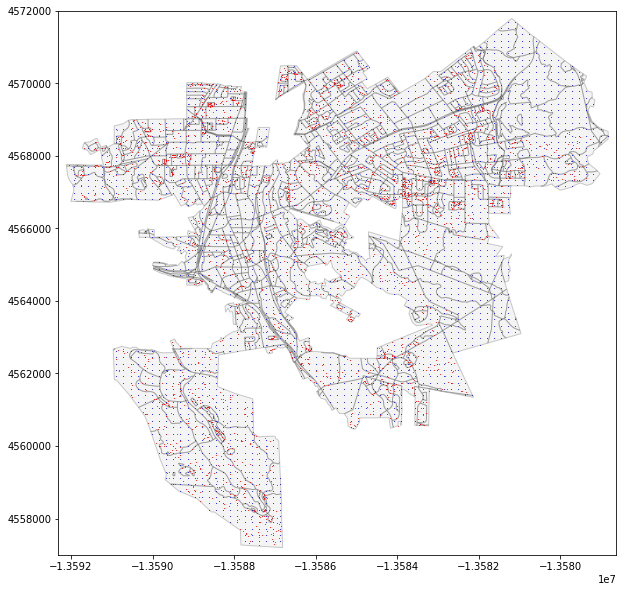

In [47]:
# plot the cut-up city
fig2, ax2 = plt.subplots(figsize=(10,10))
for polygon in wc_pop_geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax2.add_patch(patch)

#ax2.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=2)
ax2.scatter(x=points_within_geometry['x'], y=points_within_geometry['y'], s=1, c='b', linewidth=0, zorder=3)
#ax2.scatter(x=possible_matches['x'], y=possible_matches['y'], s=1, c='r', linewidth=0, zorder=2)

for i in range(0, len(pts_per_bg)):
    bgpts = pts_per_bg[i]
    if len(bgpts) > 0:
        ax2.scatter(x=bgpts['x'], y=bgpts['y'], s=1, c='r', linewidth=0, zorder=4)

ax2.set_xlim(west-200, east+200)
ax2.set_ylim(south-200, north+200)
ax2.axis('on')
#plt.savefig("grid_candpts_w_randpts.png",  dpi=192 * 10)
plt.show()


In [51]:
points_within_geometry.to_file(driver='ESRI Shapefile', filename='gridpts.shp')

### need to shift every other x or every other y for triangular pattern

# Covering

## First: Naive alg
- find all the pts that each cand pt covers
- find the best k ones

In [54]:
pp = candpts.geometry.tolist()

NameError: name 'candpts' is not defined

In [ ]:
pp[0].x

In [ ]:
pts_per_bg[0].geometry.tolist()[0].x

In [55]:
%%time
# loop to find all the pts that each cand pt covers

candcovers = []
candpts = points_within_geometry.geometry.tolist()

for i in range(0, len(candpts)):
    candpt = candpts[i]
    thiscover = []
    for j in range(0, len(pts_per_bg)):
        if len(pts_per_bg[j]) > 0 :
            ptlist = pts_per_bg[j].geometry.tolist()
            for k in range(0, len(ptlist)):
                pt = ptlist[k]
                dist = db.eucdist(pt.x, pt.y, candpt.x, candpt.y)[0]
                if dist < optdist:
                    thiscover.append(pt)
                
    candcovers.append(thiscover)
            
            
                   

KeyboardInterrupt: 

In [ ]:
for i in range(0, len(candcovers)):
    if len(candcovers[i])>0:
        print i

In [ ]:
# plot the cut-up city
fig3, ax3 = plt.subplots(figsize=(10,10))
for polygon in wc_pop_geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax3.add_patch(patch)

#ax2.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=2)
ax3.plot(tcandpts[13].x, tcandpts[13].y, 'bo', zorder=3,markersize=2.)
for i in range(0, len(candcovers[13])):
    ax3.plot(tcandcovers[13][i].x, tcandcovers[13][i].y, 'ro', zorder=2, markersize=1.)


ax3.set_xlim(west-200, east+200)
ax3.set_ylim(south-200, north+200)
ax3.axis('on')
#plt.savefig("grid_candpts_w_randpts.png",  dpi=192 * 10)
plt.show()

In [ ]:
%%time
# loop to find all the pts that each cand pt covers

tcandcovers = []
tcandpts = points_within_geometry.geometry.tolist()

for i in range(0, len(tcandpts)):
    tcandpt = tcandpts[i]
    tthiscover = []
    for j in range(0, len(pts_per_bg)):
        if len(pts_per_bg[j]) > 0 :
            tptlist = pts_per_bg[j].geometry.tolist()
            for k in range(0, len(tptlist)):
                tpt = tptlist[k]
                xdist = tpt.x-tcandpt.x
                ydist = tpt.y - tcandpt.y
                dist = math.sqrt(pow(xdist,2)+pow(ydist,2))
                if dist < optdist:
                    tthiscover.append(tpt)
                
    tcandcovers.append(tthiscover)
    

In [ ]:
# map pts to their pops
pt_pop_dict = {}
for i in range(0, len(pts_per_bg)):
    if len(pts_per_bg[i]) > 0:
        tlist = pts_per_bg[i].geometry.tolist()
        for j in range(0, len(poptest3[i])):
            pt_pop_dict[(tlist[j].x, tlist[j].y)] = poptest3[i][j]
            #testerrgrg = poptest[i][j]

In [ ]:
# map cand pts to their covers
candpt_covers = {}

for i in range(0, len(tcandpts)):
    tpt = tcandpts[i]
    candpt_covers[(tpt.x, tpt.y)] = tcandcovers[i]

In [ ]:
candpt_covers

In [ ]:
# now tally the pops for the points & sort
totalpop_coverpts = {}
notcovered = []

for i in range(0, len(tcandcovers)):
    candpt = tcandpts[i]
    candptcover = tcandcovers[i]
    
    sumpop = 0
    
    for coverpt in candptcover:
        try:
            sumpop += pt_pop_dict[(coverpt.x, coverpt.y)]
        except KeyError:
            notcovered.append(coverpt)
            
    if not sumpop== 0:
        totalpop_coverpts[(candpt.x, candpt.y)] = sumpop

    
    
    
    #for poppt, pop, in pt_pop_dict.iteritems():
        
    

In [ ]:
print len(tcandcovers)
print len(tcandpts)
print len(totalpop_coverpts)
print len(notcovered)
#print len(

In [ ]:
flat_iuheu = [j for i in tcandcovers for j in i]

In [ ]:
len(flat_iuheu)

In [ ]:
len(pt_pop_dict)

In [ ]:
# plot the cut-up city
fig4, ax4 = plt.subplots(figsize=(10,10))
for polygon in wc_pop_geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax4.add_patch(patch)


#ax2.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=2)
for i in range(0, len(candpts)):
    ax4.plot(candpts[i].x, candpts[i].y, 'bo', zorder=3,markersize=1.)
for i in range(0, len(candcovers)):
    for j in range(0, len(candcovers[i])):
        ax4.plot(candcovers[i][j].x, candcovers[i][j].y, 'ro', zorder=4, markersize=0.5)

tally = 0
for i in range(0, len(pts_per_bg)):
    bgpts = pts_per_bg[i]
    if len(bgpts) > 0:
        tally += len(bgpts)
        ax4.scatter(x=bgpts['x'], y=bgpts['y'], s=1, c='g', linewidth=0, zorder=2)


ax4.set_xlim(west-200, east+200)
ax4.set_ylim(south-200, north+200)
ax4.axis('on')
#plt.savefig("grid_candpts_w_randpts.png",  dpi=192 * 10)
plt.show()

In [ ]:
notmatch = 0
totdiff = 0
for i in range(0, len(pts_per_bg)):
    if len(pts_per_bg[i]) > len(poptest3[i]):
        notmatch+=1
        totdiff += abs(len(pts_per_bg[i])-len(poptest3[i]))
        print "pts bigger"
    elif len(pts_per_bg[i]) < len(poptest3[i]):
        notmatch+=1
        totdiff += abs(len(pts_per_bg[i])-len(poptest3[i]))
        print "pops bigger"
        

## now find top k

In [ ]:
bestcoverpts = []
for key, value in sorted(totalpop_coverpts.iteritems(), key=lambda (k,v): (v,k), reverse=True):
    #print value
    bestcoverpts.append(key)

In [ ]:
bestcoverpts[0][0]

In [ ]:
#grab the pts covered by the top k 
bestcoverpts_covers = []
for tup in bestcoverpts[0:100]:
    bestcoverpts_covers.append(candpt_covers[tup])
    

In [ ]:
# plot top 100 & their covered pts
# plot the cut-up city
fig5, ax5 = plt.subplots(figsize=(10,10))
for polygon in wc_pop_geoms:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.2, zorder=0)
    ax5.add_patch(patch)


#ax2.scatter(x=points_outside_geometry['x'], y=points_outside_geometry['y'], s=1, c='r', linewidth=0, zorder=2)
for i in range(0, len(bestcoverpts[0:100])):
    ax5.plot(bestcoverpts[i][0], bestcoverpts[i][1], 'bo', zorder=3,markersize=1.)
for i in range(0, len(bestcoverpts_covers)):
    for j in range(0, len(bestcoverpts_covers[i])):
        ax5.plot(bestcoverpts_covers[i][j].x, bestcoverpts_covers[i][j].y, 'ro', zorder=4, markersize=0.5)

tally = 0
for i in range(0, len(pts_per_bg)):
    bgpts = pts_per_bg[i]
    if len(bgpts) > 0:
        tally += len(bgpts)
        ax5.scatter(x=bgpts['x'], y=bgpts['y'], s=1, c='g', linewidth=0, zorder=2)


ax5.set_xlim(west-200, east+200)
ax5.set_ylim(south-200, north+200)
ax5.axis('on')
plt.savefig("naive_k_cover_try1.png",  dpi=192 * 10)
plt.show()

# **Genetic Algorithm** 

```START
Generate the initial population
Compute fitness
REPEAT
    Selection
    Crossover
    Mutation
    Compute fitness
UNTIL population has converged
STOP```

- initial pops = cand facility locs ("smart" initial pops?)
- selection : 1- coverage by pop, coverage of equal pops are in the same "class", (tie breaker) 2-overlap over edges? (maybe other stuff), and choose randomly from the classes

### covering alg needs to be much, much faster
let's try to use rtree

In [56]:
def find_candpt_covers(candpts, poppts_gdf, rad):
    
    #spatial index for population center pts
    poppt_sindex = poppts_gdf.sindex
    all_covers = []
    for i in range(0, len(candpts)): # for each candpt, find the pts that are covered
        cpt = candpts[i]
        bbox = (cpt.x-rad, cpt.y-rad, cpt.x+rad, cpt.y+rad)
        pt_covers = []
        for pt in poppt_sindex.intersection(bbox):
            ppt = poppts_gdf['geometry'][pt]
            dist = cpt.distance(ppt)
            if dist<rad:
                #pt_covers.append(pt)
                pt_covers.append(ppt)
        all_covers.append(pt_covers)
    
    return all_covers

#adapted from https://stackoverflow.com/questions/44622233/rtree-count-points-in-the-neighbourhoods-within-each-point-of-another-set-of-po

In [57]:
candpt_index = points_within_geometry.sindex

In [58]:
topplex = []
toppley = []
#pts_all_gdf = gpd.geodataframe()
for i in range(0, len(pts_per_bg)):
    if len(pts_per_bg[i])>0:
        tl = pts_per_bg[i].geometry.tolist()
        for j in range(0, len(tl)):
            topplex.append(tl[j].x)
            toppley.append(tl[j].y)

In [59]:
# create the GDF for the rtree intersection
pts_all_gdf = gpd.GeoDataFrame(data={'x':topplex, 'y':toppley})


# transform the grid pts for indexing
pts_all_gdf['geometry'] = pts_all_gdf.apply(lambda row: Point((row['x'], row['y'])), axis=1)


In [60]:
%%time
coverpts_rtree = find_candpt_covers(candpts, pts_all_gdf, optdist)

CPU times: user 1.19 s, sys: 10.3 ms, total: 1.2 s
Wall time: 1.21 s


In [ ]:
#now lets compare
for i in range(0, len(floopy)):
    print "RTREE \n"
    for j in range(0, len(floopy[i])):
        print str(floopy[i][j].x)+" "+str(floopy[i][j].y)
    print "OLD \n"    
    for j in range(0, len(tcandcovers[i])):
        print str(tcandcovers[i][j].x)+" "+str(tcandcovers[i][j].y)

In [ ]:
tcandcovers[0:20]

In [65]:
print coverpts_rtree[0:30]

[[], [], [], [], [], [], [], [], [], [], [], [], [], [<shapely.geometry.point.Point object at 0x1204bc090>, <shapely.geometry.point.Point object at 0x1204bc110>, <shapely.geometry.point.Point object at 0x1204c28d0>, <shapely.geometry.point.Point object at 0x1204a1c50>, <shapely.geometry.point.Point object at 0x1204c2910>, <shapely.geometry.point.Point object at 0x1204a1b90>], [<shapely.geometry.point.Point object at 0x1204c2b50>], [<shapely.geometry.point.Point object at 0x1204c2b10>, <shapely.geometry.point.Point object at 0x1204c2ad0>, <shapely.geometry.point.Point object at 0x1204c2a90>, <shapely.geometry.point.Point object at 0x12048b0d0>], [<shapely.geometry.point.Point object at 0x12047a050>, <shapely.geometry.point.Point object at 0x1204c2850>, <shapely.geometry.point.Point object at 0x1204bc190>, <shapely.geometry.point.Point object at 0x1204bc150>, <shapely.geometry.point.Point object at 0x1204bc1d0>, <shapely.geometry.point.Point object at 0x1204bc210>, <shapely.geometry.poin